# FC autoencoder for MNIST

My first experiment with autoencoders: a small network with fully connected layers to autoencode the MNIST data

## Imports

In [1]:
from fastai.vision.all import *

## Load data

In [2]:
path = untar_data(URLs.MNIST_TINY)

In [244]:
mean = 33.31
std = 78.56748962402344

def label_func(o):
    img = image2tensor(Image.open(o)).view(784).float()
    # print(img.dtype)
    img -= mean
    img /= std
    return img

dblock = DataBlock(blocks=(ImageBlock(cls=PILImageBW), RegressionBlock),
                   get_items=get_image_files, 
                   splitter=GrandparentSplitter(),
                   item_tfms=[Resize([1,784])],
                   get_y=label_func)

dls = dblock.dataloaders(path)


In [239]:
# dls.show_batch(max_n=9, figsize=(4,4))

## Create architecture

In [255]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784,128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
            nn.Linear(36, 18),
            nn.ReLU(),
            nn.Linear(18, 9),
        )

        self.decoder = nn.Sequential(
            nn.Linear(9,18),
            nn.ReLU(),
            nn.Linear(18,36),
            nn.ReLU(),
            nn.Linear(36,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,784),
            nn.ReLU(),
        )
    def forward(self, x):
        x -= mean
        x /= std
        # print(x.shape)
        # return 0
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Create Learner

In [256]:
learn = Learner(dls, AE(), loss_func=MSELossFlat())

In [257]:
# learn.lr_find()
learn.fit(10, lr=0.01)

epoch,train_loss,valid_loss,time
0,0.872298,0.875146,00:00
1,0.846046,0.868600,00:00
2,0.835186,0.867039,00:00
3,0.829933,0.866333,00:00
4,0.826682,0.865630,00:00
5,0.824904,0.866925,00:00
6,0.823420,0.870335,00:00
7,0.822309,0.869850,00:00
8,0.821456,0.868011,00:00
9,0.821250,0.864901,00:00


In [258]:
# learn.show_results()
# test_img = PILImageBW.create((path/'train/3').ls()[0])
# test_img = dls.one_batch()[0][0].cpu().numpy()
# learn.predict(test_img)
b = dls.one_batch()
_,_,preds = learn.get_preds(dl=[b], with_decoded=True)

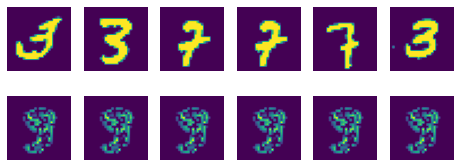

In [282]:
import torchvision.transforms as T
transform = T.ToPILImage()
n = 6
fig, ax = plt.subplots(2,n, figsize= [8,3])
for i in range(n):
    s = torch.randint(0,64,[]).item()
    plt.axes(ax[0,i])
    plt.imshow(transform(b[1][s,:].view(28,28)))
    plt.axis('off')
    plt.axes(ax[1,i])
    plt.imshow(transform(preds[s,:].view(28,28)))
    plt.axis('off')

torch.Size([64, 1, 1, 784])

In [123]:
b = dls.one_batch()
c = dls.one_batch()

In [125]:
b[1].shape

torch.Size([64, 1, 1, 784])